## Time Series Analysis for Nike


In [163]:
!pip install pandas_datareader
!pip install pmdarima
!pip install -U statsmodels

In [23]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from scipy import stats
import datetime
%matplotlib inline
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [24]:
import pandas_datareader as web  # importacion de los datos por medio de yahoo

In [25]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2022, 1, 1)
# se toma como minimo un periodo de mas de 5 años para poder tener un tiempo suficiente de analisis

In [26]:
data = web.DataReader("NKE", "yahoo", start, end)

In [27]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,61.910000,60.860001,61.110001,61.520000,11626800.0,57.274925
2016-01-05,62.590000,61.720001,61.720001,62.380001,9220600.0,58.075581
2016-01-06,62.040001,61.150002,61.299999,61.490002,6551600.0,57.246994
2016-01-07,61.259998,59.779999,60.389999,59.849998,10881300.0,55.720158
2016-01-08,60.790001,58.660000,60.060001,58.869999,11191300.0,54.807781


In [28]:
nike = data["Close"]

In [29]:
nike.head()

Date
2016-01-04    61.520000
2016-01-05    62.380001
2016-01-06    61.490002
2016-01-07    59.849998
2016-01-08    58.869999
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

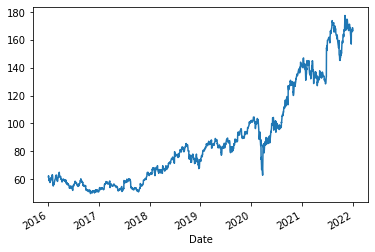

In [30]:
nike.plot()

In [31]:
Ntest = 5

train = nike.iloc[:-Ntest]
test = nike.iloc[-Ntest:]

In [32]:
model = pm.auto_arima(
    train,
    error_action="ignore",
    trace=True,
    maxiter=10,
    suppress_warnings=True,
    seasonal=False,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5782.565, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5781.598, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5779.919, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5780.181, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5782.245, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5779.806, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5781.801, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5781.806, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5780.755, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5783.772, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5780.502, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.502 seconds


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1506
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -2885.903
Date:                Wed, 28 Sep 2022   AIC                           5779.806
Time:                        17:39:07   BIC                           5801.072
Sample:                             0   HQIC                          5787.727
                               - 1506                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0699      0.044      1.588      0.112      -0.016       0.156
ar.L1         -0.0475      0.017     -2.792      0.005      -0.081      -0.014
ar.L2          0.0375      0.016      2.335      0.020       0.006       0.069
sigma2         2.7107      0.029     92.267      0.000       2.653       2.768
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31848.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.58   Skew:                             1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Modificamos la función para graficar
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params["order"][1]

    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fulldata.index, fulldata, label="data")
    ax.plot(train.index[d:], train_pred, label="fitted")
    ax.plot(test.index, test_pred, label="forecast")
    ax.fill_between(test.index, confint[:, 0], confint[:, 1], color="red", alpha=0.3)

    ax.legend()

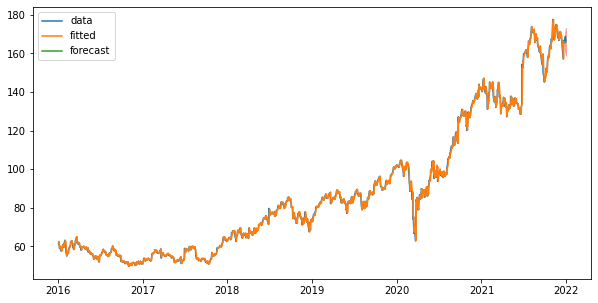

In [35]:
plot_result(model, nike, train, test)

In [36]:
def plot_test(model, test):

    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test, label="true")
    ax.plot(test.index, test_pred, label="forecast")
    ax.fill_between(test.index, confint[:, 0], confint[:, 1], color="red", alpha=0.3)

    ax.legend()

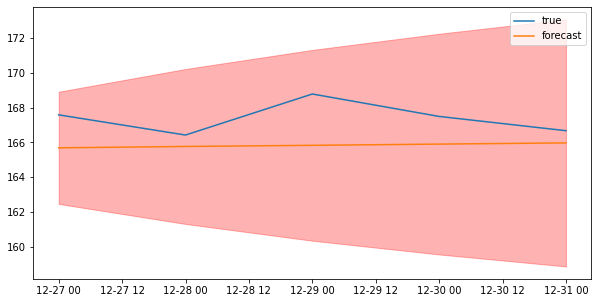

In [37]:
plot_test(model, test)

In [38]:
model.predict(Ntest)

array([165.68435806, 165.76215064, 165.82885142, 165.89845518,
       165.96750551])

In [39]:
# forecast RMSE
def rmse(t, y):
    return np.sqrt(np.mean((t - y) ** 2))

In [40]:
### Podemos comparar con el modelo Naive, el cual se basa en tomar el dato anterior para la predicción del siguiente dato
print("RMSE ARIMA:", rmse(model.predict(Ntest), test))
print("RMSE Naive:", rmse(train.iloc[-1], test))

RMSE ARIMA: 1.7755014926366717
RMSE Naive: 1.9076238856686718


In [41]:
# Para utlizar la función realizando la transformación inversa del logaritmo cambiamos .forecast por .predict
def rmse(result, is_logged):
    forecast = result.predict(Ntest)
    if is_logged:
        forecast = np.exp(forecast)
    t = test
    y = forecast
    return np.sqrt(np.mean((t - y) ** 2))

In [42]:
print("ARIMA(0,1,1):", rmse(model, False))

ARIMA(0,1,1): 1.7755014926366717


In [43]:
nike.head()

Date
2016-01-04    61.520000
2016-01-05    62.380001
2016-01-06    61.490002
2016-01-07    59.849998
2016-01-08    58.869999
Name: Close, dtype: float64

In [ ]:
## Now, Please do the same for the log price and the Log returns

In [28]:
# data['LogPrice'] = np.log(data['Close'])

In [29]:
# data['LogRet'] = data['LogPrice'].diff()